### Multi Modality Registration With Viola Wells Mutual Information

https://itk.org/ITKExamples/src/Registration/Common/PerformMultiModalityRegistrationWithMutualInformation/Documentation.html

In [1]:
import itk
from matplotlib import pyplot as plt
%matplotlib inline
itk.Version.GetITKVersion()

'4.13.0'

Cost Function : MutualInformationImageToImageMetric

Due to the stochastic nature of the metric computation, the values are too noisy to work successfully with the RegularStepGradientDescentOptimizer.  Therefore, the simpler GradientDescentOptimizer is used

In [2]:
path1 = './input_data/3a1.png'
path2 = './input_data/3a2.png'

PixelType = itk.US    # unsigned short
'''
No template (<class 'itkImagePython.itkImageUS2'>, <class 'itkImagePython.itkImageF2'>) 
for the itk::NormalizeImageFilter class
''' 
PixelType = itk.F 
Dimension = 2
FixedImageType  = itk.Image[PixelType, Dimension]
MovingImageType = itk.Image[PixelType, Dimension]

FixedImageReaderType  = itk.ImageFileReader[FixedImageType]
MovingImageReaderType = itk.ImageFileReader[MovingImageType]

fixedImageReader  = FixedImageReaderType.New()
movingImageReader = MovingImageReaderType.New()

fixedImageFile = path1
movingImageFile = path2

fixedImageReader.SetFileName(fixedImageFile)
movingImageReader.SetFileName(movingImageFile)

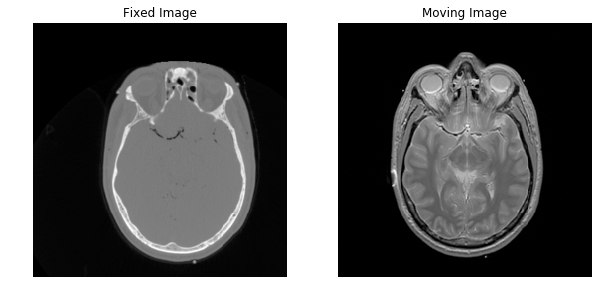

In [3]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(itk.GetArrayViewFromImage(fixedImageReader.GetOutput()), cmap=plt.get_cmap('gray'))
ax1.axis('off')
ax1.set_title('Fixed Image')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(itk.GetArrayViewFromImage(movingImageReader.GetOutput()), cmap=plt.get_cmap('gray'))
ax2.set_title('Moving Image')
ax2.axis('off')
plt.show()

In [4]:
InternalPixelType = itk.F
InternalImageType = itk.Image[InternalPixelType, Dimension]

In [5]:
TransformType    = itk.TranslationTransform[itk.D, Dimension]
OptimizerType    = itk.GradientDescentOptimizer
InterpolatorType = itk.LinearInterpolateImageFunction[InternalImageType, itk.D]
RegistrationType = itk.ImageRegistrationMethod[InternalImageType, InternalImageType]  
MetricType       = itk.MutualInformationImageToImageMetric[InternalImageType, InternalImageType]

transform     = TransformType.New()
optimizer     = OptimizerType.New()
interpolator  = InterpolatorType.New()
registration  = RegistrationType.New()
metric        = MetricType.New()

registration.SetOptimizer(optimizer)
registration.SetTransform(transform)
registration.SetInterpolator(interpolator)
registration.SetMetric(metric)

Normalize the statistical distribution of the two input images to simplify the computation of the mutual information
i.e. rescale the intensities of the input images in order to produce an output image with zero mean and unit variance

In [6]:
FixedNormalizeFilterType  = itk.NormalizeImageFilter[FixedImageType,  InternalImageType]
MovingNormalizeFilterType = itk.NormalizeImageFilter[MovingImageType, InternalImageType]

fixedNormalizer  = FixedNormalizeFilterType.New()
movingNormalizer = MovingNormalizeFilterType.New()

Additionally, low-pass filtering of the images to be registered will also increase robustness against noise

In [7]:
GaussianFilterType = itk.DiscreteGaussianImageFilter[ InternalImageType, InternalImageType]
fixedSmoother  = GaussianFilterType.New()
movingSmoother = GaussianFilterType.New()

fixedSmoother.SetVariance( 2.0 )
movingSmoother.SetVariance( 2.0 )

# standard deviation of the Gaussian kernel
metric.SetFixedImageStandardDeviation(0.4)
metric.SetMovingImageStandardDeviation(0.4)

In [8]:
fixedNormalizer.SetInput(  fixedImageReader.GetOutput() )
movingNormalizer.SetInput( movingImageReader.GetOutput() )

fixedSmoother.SetInput( fixedNormalizer.GetOutput() )
movingSmoother.SetInput( movingNormalizer.GetOutput() )

In [9]:
registration.SetFixedImage(    fixedSmoother.GetOutput()    )
registration.SetMovingImage(   movingSmoother.GetOutput()   )
fixedNormalizer.Update()

In [10]:
fixedImageRegion = fixedNormalizer.GetOutput().GetBufferedRegion()
registration.SetFixedImageRegion( fixedImageRegion )

In [11]:
initialParameters = transform.GetParameters()
initialParameters[0] = 0.0 # Initial offset in mm along X
initialParameters[1] = 0.0 # Initial offset in mm along Y

registration.SetInitialTransformParameters( initialParameters )

We should now define the number of spatial samples to be considered in the metric computation. Note that we were forced to postpone this setting until we had done the preprocessing of the images because the number of samples is usually defined as a fraction of the total number of pixels in the fixed image.
<br><br>
The number of spatial samples can usually be as low as $1\%$ of the total number of pixels in the fixed image. Increasing the number of samples improves the smoothness of the metric from one iteration to another and therefore helps when this metric is used in conjunction with optimizers that rely of the continuity of the metric values. The trade-off, of course, is that a larger number of samples result in longer computation times per every evaluation of the metric.

In [12]:
numberOfPixels = fixedImageRegion.GetNumberOfPixels()
numberOfSamples = numberOfPixels * 0.01
numberOfSamples = int(numberOfSamples)

In [13]:
metric.SetNumberOfSpatialSamples( numberOfSamples )
metric.ReinitializeSeed( 121212 ) # For consistent results when regression testing

In [14]:
optimizer.SetNumberOfIterations( 400 )
# Since larger values of mutual information indicate better matches than smaller values, 
# we need to maximize the cost function
optimizer.MaximizeOn()
optimizer.SetLearningRate( 15.0 )

In [15]:
registration.Update()

In [16]:
finalParameters = registration.GetLastTransformParameters()
TranslationAlongX = finalParameters[0]
TranslationAlongY = finalParameters[1]
numberOfIterations = optimizer.GetCurrentIteration()
bestValue = optimizer.GetValue()

In [17]:
print("Result = ")
print(" Translation X = " + str(TranslationAlongX))
print(" Translation Y = " + str(TranslationAlongY))
print(" Iterations    = " + str(numberOfIterations))
print(" Metric value  = " + str(bestValue))
print(" Numb. Samples = " + str(numberOfSamples))

Result = 
 Translation X = -17.989705227610926
 Translation Y = -4.419029234727178
 Iterations    = 400
 Metric value  = 0.6204288819918204
 Numb. Samples = 655


In [18]:
finalTransform = TransformType.New()
finalTransform.SetParameters( finalParameters )
finalTransform.SetFixedParameters( transform.GetFixedParameters() )

In [19]:
ResampleFilterType = itk.ResampleImageFilter[MovingImageType, FixedImageType]
resample = ResampleFilterType.New()
resample.SetTransform( finalTransform )
resample.SetInput( movingImageReader.GetOutput() )

In [20]:
fixedImage = fixedImageReader.GetOutput()

resample.SetSize(    fixedImage.GetLargestPossibleRegion().GetSize() )
resample.SetOutputOrigin(  fixedImage.GetOrigin() )
resample.SetOutputSpacing( fixedImage.GetSpacing() )
resample.SetOutputDirection( fixedImage.GetDirection() )
resample.SetDefaultPixelValue( 100 )

In [21]:
OutputPixelType = itk.ctype('unsigned char')
OutputImageType = itk.Image[OutputPixelType, Dimension]

resample.Update()

In [22]:
difference = itk.SubtractImageFilter.New(Input1=fixedImage, Input2=resample)
resample.SetDefaultPixelValue(1)

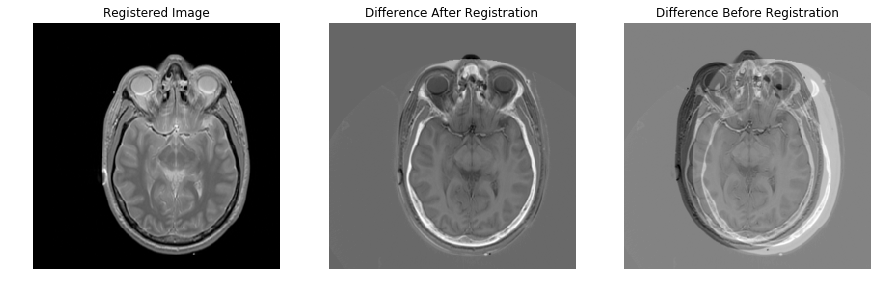

In [23]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(itk.GetArrayViewFromImage(resample), cmap=plt.get_cmap('gray'))
ax1.axis('off')
ax1.set_title('Registered Image')
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(itk.GetArrayViewFromImage(difference), cmap=plt.get_cmap('gray'))
ax2.set_title('Difference After Registration')
ax2.axis('off')

identityTransform = TransformType.New()
identityTransform.SetIdentity()
resample.SetTransform(identityTransform)
difference.Update()

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(itk.GetArrayViewFromImage(difference), cmap=plt.get_cmap('gray'))
ax3.set_title('Difference Before Registration')
ax3.axis('off')

plt.show()

### Fixed/moving image checkerboard

In [24]:
CheckerBoardFilterType = itk.CheckerBoardImageFilter[FixedImageType]
checker = CheckerBoardFilterType.New()
checker.SetInput1( fixedImage )
checker.SetInput2( resample.GetOutput() )

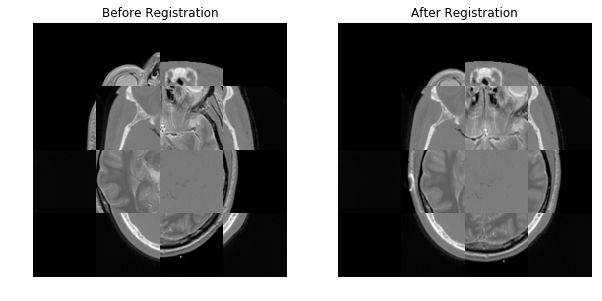

In [25]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(itk.GetArrayViewFromImage(checker), cmap=plt.get_cmap('gray'))
ax1.axis('off')
ax1.set_title('Before Registration')

resample.SetTransform( finalTransform )
checker.SetInput2( resample.GetOutput() )

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(itk.GetArrayViewFromImage(checker), cmap=plt.get_cmap('gray'))
ax2.set_title('After Registration')
ax2.axis('off')
plt.show()

### Comparison with Deep Learning <br><br>

James M. Sloan, Keith A. Goatman, Jan Paul Siebert, "Learning Rigid Image Registration - Utilizing Convolutional Neural Networks for Medical Image Registration", BIOIMAGING 2018
<br>http://www.scitepress.org/Papers/2018/65437/65437.pdf<br><br>
Xiaohuan Cao, Jianhua Yang, Li Wang, Zhong Xue, Qian Wang, Dinggang Shen, "Deep Learning based Inter-Modality Image Registration Supervised by Intra-Modality Similarity", Arxiv: 1804.10735
<br>https://arxiv.org/pdf/1804.10735.pdf
<br><br>
Zhuoqian Yang, Tingting Dan, Yang Yang, "Multi-temporal Remote Sensing Image Registration Using Deep Convolutional Features", July 2018 IEEE Access PP(99):1-1 <br>
www.researchgate.net/publication/326213864_Multi-temporal_Remote_Sensing_Image_Registration_Using_Deep_Convolutional_Features
https://ieeexplore.ieee.org/document/8404075
<br><br>
Kuan Liu, Yanen Li, Ning Xu, Prem Natarajan, "Learn to Combine Modalities in Multimodal Deep Learning", Submitted to KDD 2018  <br>
https://arxiv.org/pdf/1805.11730.pdf